In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import scipy.io as sio
from mpl_toolkits.basemap import Basemap, cm
import gsw as sw
import scipy as sc

from netCDF4 import Dataset

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

In [2]:
# import cruise data

in_file = '../data/KuroAlldata.csv'
data = pd.read_csv(in_file, sep = ',').dropna(axis=0, subset=['depth (m)'])

data['theta'] = sw.conversions.pt_from_t(data['S'], data['T(C)'], data['depth (m)'])

data['transect'] = 0
data.loc[(data['station']<9),'transect'] = 'A'
data.loc[((data['station']>8) & (data['station']<17)),'transect'] = 'B'
data.loc[((data['station']>16) & (data['station']<26)),'transect'] = 'C'
data.loc[((data['station']>25) & (data['station']<34)),'transect'] = 'D'
data.loc[(data['station']>33),'transect'] = 'E'

data = data[data['station']!= 41]

data['station'] = data['transect'] + data['station'].astype(str) 
data['sample'] = data['station'] + '-' + data['depth (m)'].astype(int).astype(str)
data.set_index('sample', inplace = True)

# import and merge phytoplankton counts
in_file = '../data/Kuroshio_Phytoplankton.xlsx'
phyto = pd.read_excel(in_file, sheet_name = 'PFTs')
phyto = phyto[phyto['STATION']!='E41']

phyto['sample'] = phyto["STATION"] + '-' + phyto["depth"].astype(int).astype(str)
phyto.set_index('sample', inplace = True)

phyto = phyto[phyto['depth']<80]

data = data.loc[phyto.index, :]

print len(data), len(phyto)

149 149


/Users/sclayton/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:809: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/sclayton/anaconda/lib/python2.7/site-packages/gsw-3.0.3-py2.7.egg/gsw/utilities/utilities.py:251: RuntimeWarning: invalid value encountered in less
  SA[SA < 0] = np.ma.masked
/Users/sclayton/anaconda/lib/python2.7/site-packages/gsw-3.0.3-py2.7.egg/gsw/gibbs/library.py:899: RuntimeWarning: invalid value encountered in greater
  nonzero_SA = np.any(SA > 0)


In [3]:
int_phyto = phyto.groupby('STATION').agg({'latitude': np.mean, 'longitude':np.mean, u'Oscillatoriaceae': np.sum,
       u'Cryptophytes':np.sum, u'Haptophytes':np.sum, u'Euglenophytes':np.sum, u'Prasinophytes':np.sum,
       u'Diatoms':np.sum, u'Dinoflagellates':np.sum})


In [4]:
int_phyto.loc['A1','Diatoms']

960

In [5]:
# integrate phyto data properly

int_phyto = phyto.groupby('STATION').agg({'latitude': np.mean, 'longitude':np.mean, u'Oscillatoriaceae': np.sum,
       u'Cryptophytes':np.sum, u'Haptophytes':np.sum, u'Euglenophytes':np.sum, u'Prasinophytes':np.sum,
       u'Diatoms':np.sum, u'Dinoflagellates':np.sum})

pft = [u'Oscillatoriaceae', u'Cryptophytes', u'Haptophytes', u'Euglenophytes', u'Prasinophytes',u'Diatoms', u'Dinoflagellates']

for st in int_phyto.index:
    for pp in pft:
        y = np.array(phyto.loc[phyto.STATION == st, [pp]].values)/0.001 # to convert to cells/m3
        x = np.array(phyto.loc[phyto.STATION == st, ['depth']].values)
    
        tmp = np.sum((x[1:] - x[0:-1])*((y[0:-1] + y[1:])/2))#/np.max(x)
        int_phyto.loc[st,pp] = tmp



In [6]:
# import MDT data
infile = '../../kuroshio_chapter/data/sla/dt_global_allsat_msla_h_20091020_20140106.nc'
mdt_data = Dataset(infile, mode='r')

mdt_data.variables

mdt = np.squeeze(mdt_data.variables['sla'])
lats = mdt_data.variables['lat'][:]
lons = mdt_data.variables['lon'][:]

lon_mdt, lat_mdt = np.meshgrid(lons, lats)

mdt[mdt<-3] = np.nan

/Users/sclayton/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1638: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/sclayton/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/sclayton/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3442: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'lw'
  s)
/Users/sclayton/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3509: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matpl

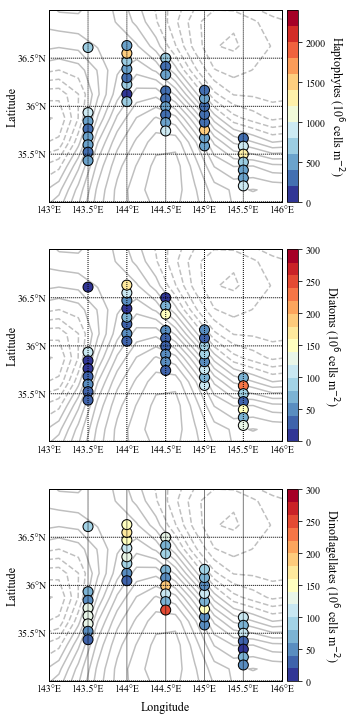

In [7]:
fig0 = plt.figure(figsize=(5., 10.5), dpi = 300)

palette = plt.get_cmap('RdYlBu_r', 12)

ax1 = fig0.add_subplot(311)
m = Basemap(projection='merc',llcrnrlat=35.,urcrnrlat=37.,\
            llcrnrlon=143.,urcrnrlon=146.,lat_ts=0,resolution='c', ax = ax1)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
m.drawparallels(np.arange(30,50,0.5),labels=[1,0,0,0])
m.drawmeridians(np.arange(138,153,0.5),labels=[1,1,0,1])

xii, yii = m(lon_mdt, lat_mdt)
m.contour(xii,yii,mdt,levels = np.arange(-2, 2, 0.05), colors = 'grey', lw = 5, zorder = 1, alpha = 0.5)

xi, yi = m(int_phyto['longitude'].values, int_phyto['latitude'].values)
hh = m.scatter(xi, yi, s = 100, c = int_phyto['Haptophytes']/10**6, cmap = palette, marker = 'o', edgecolors = 'k', vmin = 0, vmax = 2400)

cbh = m.colorbar(hh)
cbh.set_label('Haptophytes (10$^6$ cells m$^{-2}$)',  fontsize=12, rotation = 270, labelpad = 20)

ax1.tick_params(axis='both', which='major')
ax1.tick_params(axis='both', which='minor')
ax1.set_ylabel('Latitude', labelpad = 30,  fontsize=12)

# plot diatoms
palette = plt.get_cmap('RdYlBu_r', 15)

ax2 = fig0.add_subplot(312)
m = Basemap(projection='merc',llcrnrlat=35.,urcrnrlat=37.,\
            llcrnrlon=143.,urcrnrlon=146.,lat_ts=0,resolution='c', ax = ax2)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
m.drawparallels(np.arange(30,50,0.5),labels=[1,0,0,0])
m.drawmeridians(np.arange(138,153,0.5),labels=[1,1,0,1])

m.contour(xii,yii,mdt,levels = np.arange(-2, 2, 0.05), colors = 'grey', lw = 5, zorder = 1, alpha = 0.5)

dt = m.scatter(xi, yi, s = 100, c = int_phyto['Diatoms']/10**6, cmap = palette, marker = 'o', edgecolors = 'k', vmin = 0, vmax = 300)

cbdt = m.colorbar(dt)
cbdt.set_label('Diatoms (10$^6$ cells m$^{-2}$)',  fontsize=12, rotation = 270, labelpad = 20)

ax2.tick_params(axis='both', which='major')
ax2.tick_params(axis='both', which='minor')
ax2.set_ylabel('Latitude', labelpad = 30,  fontsize=12)

# plot dinoflagellates
ax3 = fig0.add_subplot(313)
m = Basemap(projection='merc',llcrnrlat=35.,urcrnrlat=37.,\
            llcrnrlon=143.,urcrnrlon=146.,lat_ts=0,resolution='c', ax = ax3)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
m.drawparallels(np.arange(30,50,0.5),labels=[1,0,0,0])
m.drawmeridians(np.arange(138,153,0.5),labels=[1,1,0,1])

m.contour(xii,yii,mdt,levels = np.arange(-2, 2, 0.05), colors = 'grey', lw = 5, zorder = 1, alpha = 0.5)

di = m.scatter(xi, yi, s = 100, c = int_phyto['Dinoflagellates']/10**6, cmap = palette, marker = 'o', edgecolors = 'k', vmin = 0, vmax = 300)

cbdi = m.colorbar(di)
cbdi.set_label('Dinoflagellates (10$^6$ cells m$^{-2}$)',  fontsize=12, rotation = 270, labelpad = 20)

ax3.tick_params(axis='both', which='major')
ax3.tick_params(axis='both', which='minor')
ax3.set_ylabel('Latitude', labelpad = 30,  fontsize=12)
ax3.set_xlabel('Longitude', labelpad = 20,  fontsize=12)

fig0.savefig('../figures/int_pfts.png', dpi = 300, bbox_inches='tight')

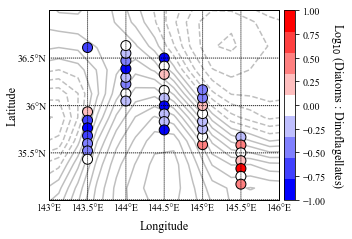

In [13]:
fig1 = plt.figure(figsize=(5., 5.), dpi = 300)

palette = plt.get_cmap('bwr', 9)

ax1 = fig1.add_subplot(111)
m = Basemap(projection='merc',llcrnrlat=35.,urcrnrlat=37.,\
            llcrnrlon=143.,urcrnrlon=146.,lat_ts=0,resolution='c', ax = ax1)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
m.drawparallels(np.arange(30,50,0.5),labels=[1,0,0,0])
m.drawmeridians(np.arange(138,153,0.5),labels=[1,1,0,1])

xii, yii = m(lon_mdt, lat_mdt)
m.contour(xii,yii,mdt,levels = np.arange(-2, 2, 0.05), colors = 'grey', lw = 5, zorder = 1, alpha = 0.5)

xi, yi = m(int_phyto['longitude'].values, int_phyto['latitude'].values)
hh = m.scatter(xi, yi, s = 100, c = np.log10(int_phyto['Diatoms'].values/int_phyto['Dinoflagellates'].values), vmin = -1 , vmax = 1, cmap = palette, marker = 'o', edgecolors = 'k')

cbh = m.colorbar(hh)
cbh.set_label('Log$_{10}$ (Diatoms : Dinoflagellates)',  fontsize=12, rotation = 270, labelpad = 20)

ax1.tick_params(axis='both', which='major',  labelsize=12)
ax1.tick_params(axis='both', which='minor',  labelsize=12)
ax1.set_ylabel('Latitude', labelpad = 30,  fontsize=12)
ax1.set_xlabel('Longitude', labelpad = 20,  fontsize=12)

fig1.savefig('../figures/diatom_dino_ratio.png', dpi = 300, bbox_inches='tight')

-0.0265337344535 2.15321003268 -0.133436307853 0.411734781264


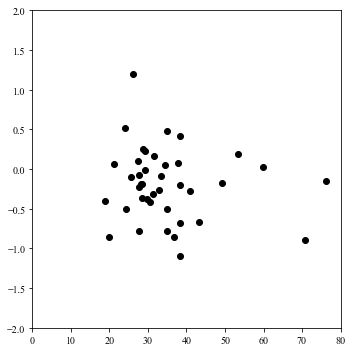

In [25]:
int_chl = pd.read_csv('../data/int_CHL.csv', sep = ',')

fig2 = plt.figure(figsize=(5., 5.), dpi = 300)

palette = plt.get_cmap('bwr', 9)

plt.plot(int_chl['chl'], np.log10(int_phyto['Diatoms'].values/int_phyto['Dinoflagellates'].values),'ok')
plt.xlim([0, 80])
plt.ylim([-2, 2])

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(int_chl['chl'],int_phyto['Diatoms'].values/int_phyto['Dinoflagellates'].values)

print slope, intercept, r_value, p_value
# ax1.tick_params(axis='both', which='major',  labelsize=12)
# ax1.tick_params(axis='both', which='minor',  labelsize=12)
# ax1.set_ylabel('Latitude', labelpad = 30,  fontsize=12)
# ax1.set_xlabel('Longitude', labelpad = 20,  fontsize=12)